## **Section 1: Setup and Installations**

In [ ]:
!pip install spacy imbalanced-learn xgboost ipywidgets
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import joblib
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from google.colab import drive
from tqdm import tqdm

## **Section 2: Configuration and Initialization**

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Initialize spaCy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Configure display options
pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Path configurations
DATASETS = {
    "amazon": Path("/content/drive/MyDrive/NLPDataset/amazon.csv"),
    "imdb": Path("/content/drive/MyDrive/NLPDataset/imdb.csv")
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 102.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Using device: cuda


## **Section 3: Data Loading Function**

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_data(path):
    """
    Load dataset and prepare for classification

    Args:
        path (str): Path to the dataset

    Returns:
        tuple: Processed DataFrame, class names, dataset type, text column, target column, label encoder
    """
    # Read the CSV file
    df = pd.read_csv(path)
    path_str = str(path).lower()

    # Determine text and target columns based on dataset
    if 'amazon' in path_str:
        text_col = 'review'
        target_col = 'category'
        dataset_type = 'amazon'
    else:
        text_col = next(col for col in ['text', 'review', 'comment', 'message'] if col in df.columns)
        target_col = next(col for col in ['sentiment', 'label'] if col in df.columns)
        dataset_type = 'imdb'

    # Encode labels
    le = LabelEncoder()
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df['encoded_labels'] = le.fit_transform(df[target_col])

    return df, le.classes_, dataset_type, text_col, target_col, le

# Example usage
df_amazon, class_names_amazon, dataset_type_amazon, text_col_amazon, target_col_amazon, le_amazon = load_data(DATASETS['amazon'])
print("\n=== Amazon Dataset Loaded Successfully ===")
print("Dataset Type:", dataset_type_amazon)
print("Class Names:", class_names_amazon)
print("Text Column:", text_col_amazon)
print("Target Column:", target_col_amazon)

# Load IMDb dataset
df_imdb, class_names_imdb, dataset_type_imdb, text_col_imdb, target_col_imdb, le_imdb = load_data(DATASETS['imdb'])
print("\n=== IMDb Dataset Loaded Successfully ===")
print("Dataset Type:", dataset_type_imdb)
print("Class Names:", class_names_imdb)
print("Text Column:", text_col_imdb)
print("Target Column:", target_col_imdb)


=== Amazon Dataset Loaded Successfully ===
Dataset Type: amazon
Class Names: ['packaging' 'pricing' 'quality' 'service' 'shipping']
Text Column: review
Target Column: category

=== IMDb Dataset Loaded Successfully ===
Dataset Type: imdb
Class Names: ['negative' 'positive']
Text Column: review
Target Column: sentiment


## **Section 4: Exploratory Data Analysis (EDA)**

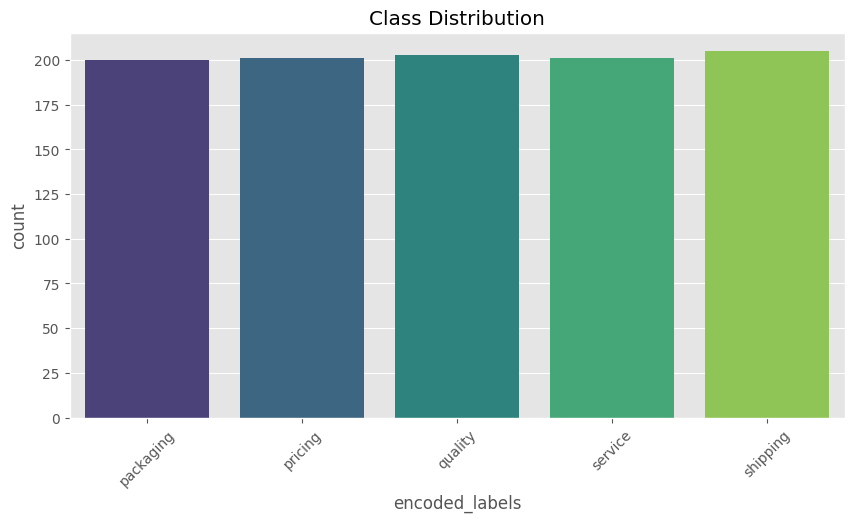

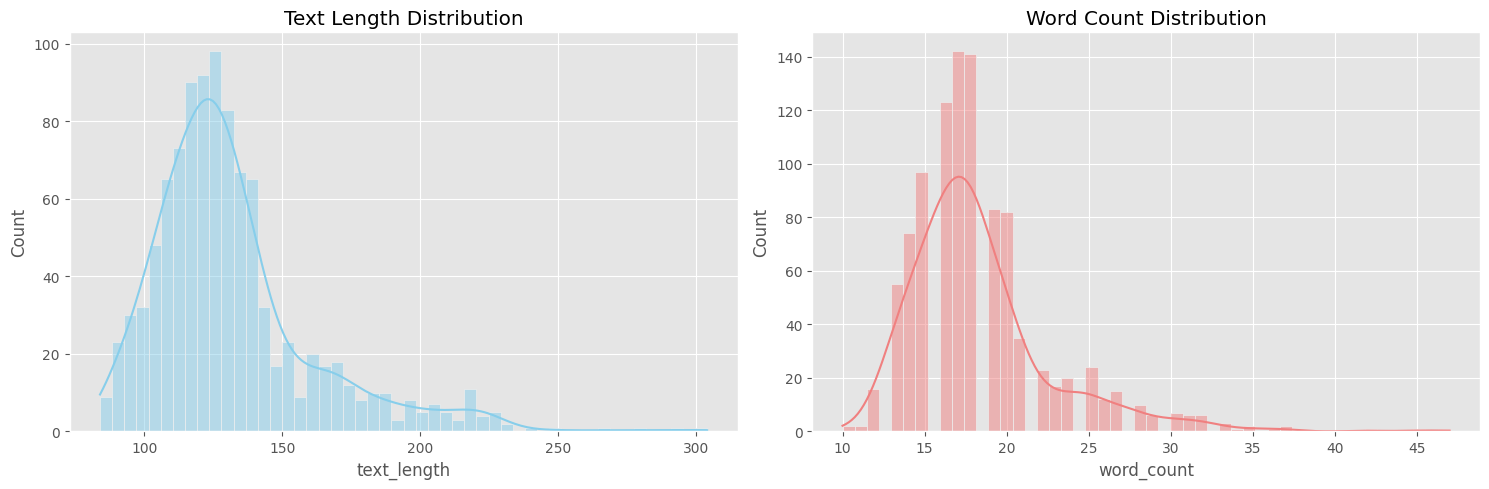

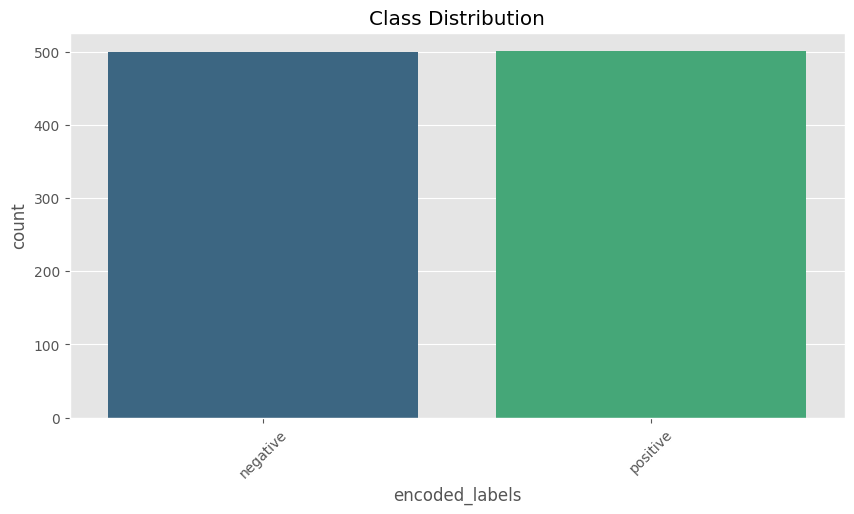

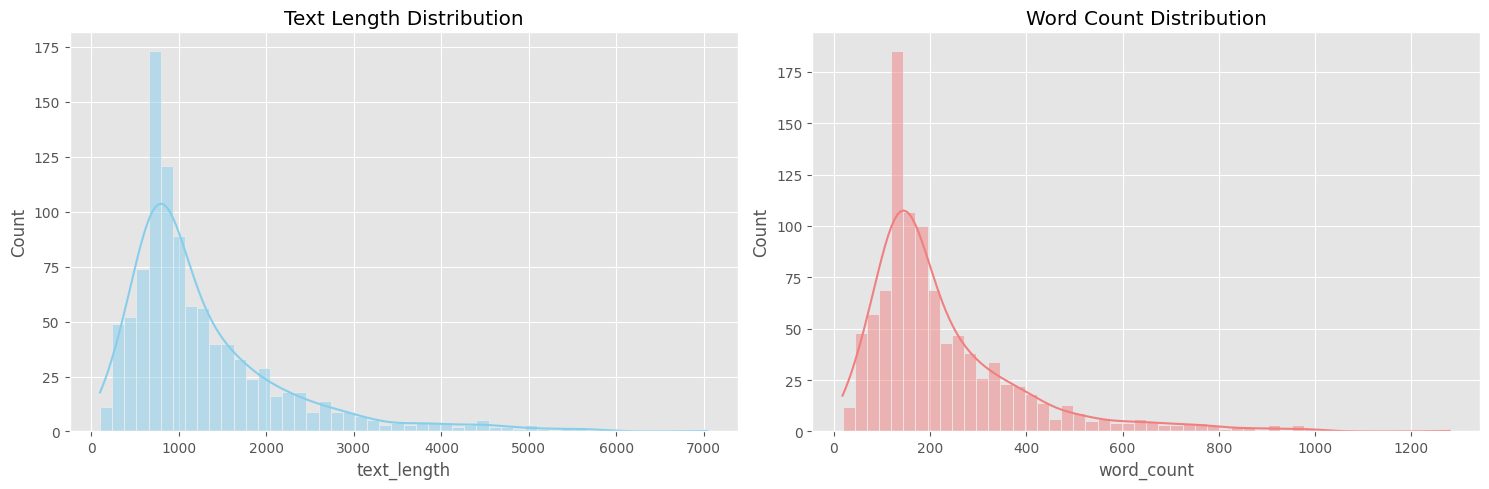

In [ ]:
def show_eda(df, class_names, text_col):
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df['encoded_labels'], palette='viridis')
    plt.title("Class Distribution")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.show()

    # Add text length and word count features
    df['text_length'] = df[text_col].apply(len)
    df['word_count'] = df[text_col].apply(lambda x: len(x.split()))

    # Plot text length and word count distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df['text_length'], bins=50, ax=ax1, kde=True, color='skyblue')
    ax1.set_title("Text Length Distribution")

    sns.histplot(df['word_count'], bins=50, ax=ax2, kde=True, color='lightcoral')
    ax2.set_title("Word Count Distribution")

    plt.tight_layout()
    plt.show()

# Show EDA for Amazon dataset
show_eda(df_amazon, class_names_amazon, text_col_amazon)

# Show EDA for IMDb dataset
show_eda(df_imdb, class_names_imdb, text_col_imdb)



## **Section 5: Text Preprocessing**

In [ ]:
def preprocess_text(text, dataset_type):
    """
    Preprocess text by cleaning, lemmatizing, and removing stopwords

    Args:
        text (str): Input text
        dataset_type (str): Type of dataset (amazon or imdb)

    Returns:
        str: Preprocessed text
    """
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Use spaCy for advanced text processing
    doc = nlp(text.lower())

    # Lemmatization and stopword removal
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha and len(token.lemma_) > 2
    ]

    # Additional feature extraction for amazon dataset
    if dataset_type == 'amazon':
        lemmas += [
            token.text.lower()
            for token in doc
            if token.pos_ in ['ADJ', 'ADV'] and len(token.text) > 2
        ]

    return ' '.join(lemmas)

# Example usage
sample_text = "I absolutely loved the acting and the direction was phenomenal!"
cleaned_text = preprocess_text(sample_text, 'imdb')
print("Original Text:", sample_text)
print("Cleaned Text:", cleaned_text)

Original Text: I absolutely loved the acting and the direction was phenomenal!
Cleaned Text: absolutely love acting direction phenomenal


## **Section 6: Model Architectures**

In [ ]:
# MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dims, output_dim, pad_idx, max_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * max_length, hidden_dims),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dims, hidden_dims//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dims//2, output_dim)
        )

    def forward(self, text):
        embedded = self.embedding(text)
        flattened = self.flatten(embedded)
        return self.fc(flattened)

# CNN Model
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=1, bidirectional=True, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if num_layers > 1 else 0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        hidden = self.dropout(hidden)
        return self.fc(hidden)

class SimpleTokenizer:
    def __init__(self, max_words=10000, oov_token='<OOV>', pad_token='<PAD>'):
        self.max_words = max_words
        self.oov_token = oov_token
        self.pad_token = pad_token
        self.word_index = {pad_token: 0, oov_token: 1}
        self.word_counts = {}
        self.num_words = 2

    def fit_on_texts(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.word_counts:
                    self.word_counts[word] = 1
                else:
                    self.word_counts[word] += 1
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        for word, count in sorted_words:
            if self.num_words < self.max_words:
                self.word_index[word] = self.num_words
                self.num_words += 1

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for word in text.split():
                sequence.append(self.word_index.get(word, 1))
            sequences.append(sequence)
        return sequences

    def get_vocab_size(self):
        return len(self.word_index)

## **Section 7: Training Utilities**

In [ ]:
def prepare_lstm_data(df, text_col, max_words=10000, max_sequence_length=150):
    tokenizer = SimpleTokenizer(max_words=max_words)
    tokenizer.fit_on_texts(df[text_col].values)
    sequences = tokenizer.texts_to_sequences(df[text_col].values)
    padded_sequences = []
    for seq in sequences:
        padded = seq[:max_sequence_length] + [0]*(max_sequence_length - len(seq))
        padded_sequences.append(padded)
    padded_sequences = np.array(padded_sequences)
    return {
        'tokenizer': tokenizer,
        'sequences': padded_sequences,
        'vocab_size': tokenizer.get_vocab_size(),
        'max_length': max_sequence_length
    }

def train_model(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        acc = ((predictions.argmax(1) == labels).float().sum() / len(labels)).item()
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_model(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in iterator:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            acc = ((predictions.argmax(1) == labels).float().sum() / len(labels)).item()
            epoch_loss += loss.item()
            epoch_acc += acc
            all_preds.extend(predictions.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_preds, all_labels

def validate_dl_model(X, y, dataset_type, model_class, model_kwargs, n_splits=5, batch_size=32, epochs=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    histories = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    fold = 1

    X_tensor = torch.tensor(X, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)

    for train_idx, val_idx in skf.split(X, y):
        print(f"\nTraining fold {fold}/{n_splits}...")
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        if dataset_type == 'amazon':
            smote = SMOTE(random_state=42)
            X_train_np = X_train.numpy().reshape(X_train.shape[0], -1)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train.numpy())
            X_train = torch.tensor(X_train_resampled.reshape(-1, X_train.shape[1]), dtype=torch.long)
            y_train = torch.tensor(y_train_resampled, dtype=torch.long)

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = model_class(**model_kwargs).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        patience, patience_counter = 2, 0
        for epoch in range(epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'model_fold_{fold}.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        model.load_state_dict(torch.load(f'model_fold_{fold}.pt'))
        _, val_acc, val_preds, val_true = evaluate_model(model, val_loader, criterion, device)
        acc = accuracy_score(val_true, val_preds)
        f1 = f1_score(val_true, val_preds, average='weighted')
        accuracies.append(acc)
        f1_scores.append(f1)
        fold += 1

    return {
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores)
    }

## **Section 8: Model Training and Evaluation**


=== LSTM Processing ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 1.5169 | Train Acc: 0.4779 | Val Loss: 1.4101 | Val Acc: 0.6893
Epoch 2/5 | Train Loss: 1.1626 | Train Acc: 0.7671 | Val Loss: 0.9578 | Val Acc: 0.7580
Epoch 3/5 | Train Loss: 0.7008 | Train Acc: 0.8514 | Val Loss: 0.5788 | Val Acc: 0.8616
Epoch 4/5 | Train Loss: 0.3641 | Train Acc: 0.9195 | Val Loss: 0.4287 | Val Acc: 0.8786
Epoch 5/5 | Train Loss: 0.1921 | Train Acc: 0.9543 | Val Loss: 0.3514 | Val Acc: 0.9152

Training fold 2/5...
Epoch 1/5 | Train Loss: 1.5345 | Train Acc: 0.4550 | Val Loss: 1.4125 | Val Acc: 0.7063
Epoch 2/5 | Train Loss: 1.2247 | Train Acc: 0.7582 | Val Loss: 1.0196 | Val Acc: 0.7429
Epoch 3/5 | Train Loss: 0.7194 | Train Acc: 0.8267 | Val Loss: 0.6713 | Val Acc: 0.7768
Epoch 4/5 | Train Loss: 0.3879 | Train Acc: 0.9096 | Val Loss: 0.5458 | Val Acc: 0.8509
Epoch 5/5 | Train Loss: 0.2388 | Train Acc: 0.9572 | Val Loss: 0.3979 | Val Acc: 0.8911

Training fold 3/5...
Epoch 1/5 | Train Loss: 1.537

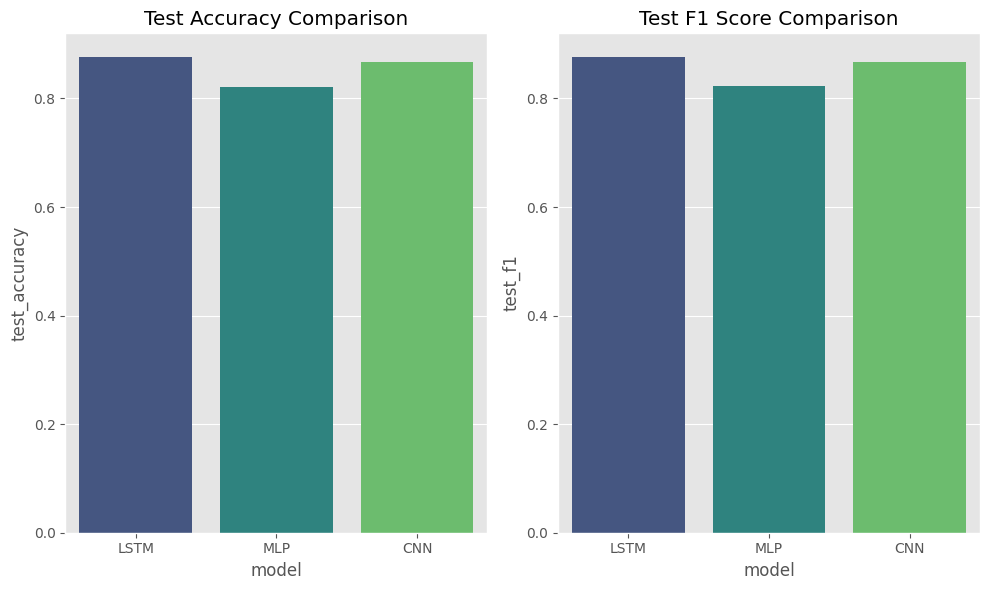


=== LSTM Processing ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 0.7015 | Train Acc: 0.4850 | Val Loss: 0.6975 | Val Acc: 0.5089
Epoch 2/5 | Train Loss: 0.6653 | Train Acc: 0.6438 | Val Loss: 0.7020 | Val Acc: 0.5179
Epoch 3/5 | Train Loss: 0.6399 | Train Acc: 0.6800 | Val Loss: 0.6978 | Val Acc: 0.4911

Training fold 2/5...
Epoch 1/5 | Train Loss: 0.6975 | Train Acc: 0.5112 | Val Loss: 0.7045 | Val Acc: 0.4286
Epoch 2/5 | Train Loss: 0.6644 | Train Acc: 0.6125 | Val Loss: 0.7071 | Val Acc: 0.4330
Epoch 3/5 | Train Loss: 0.6242 | Train Acc: 0.6975 | Val Loss: 0.7318 | Val Acc: 0.4196

Training fold 3/5...
Epoch 1/5 | Train Loss: 0.6947 | Train Acc: 0.4850 | Val Loss: 0.7112 | Val Acc: 0.3884
Epoch 2/5 | Train Loss: 0.6662 | Train Acc: 0.6200 | Val Loss: 0.7172 | Val Acc: 0.4330
Epoch 3/5 | Train Loss: 0.6299 | Train Acc: 0.6987 | Val Loss: 0.7156 | Val Acc: 0.4643

Training fold 4/5...
Epoch 1/5 | Train Loss: 0.6980 | Train Acc: 0.4725 | Val Loss: 0.6993 | Val Acc: 0.4509
Epoch 2

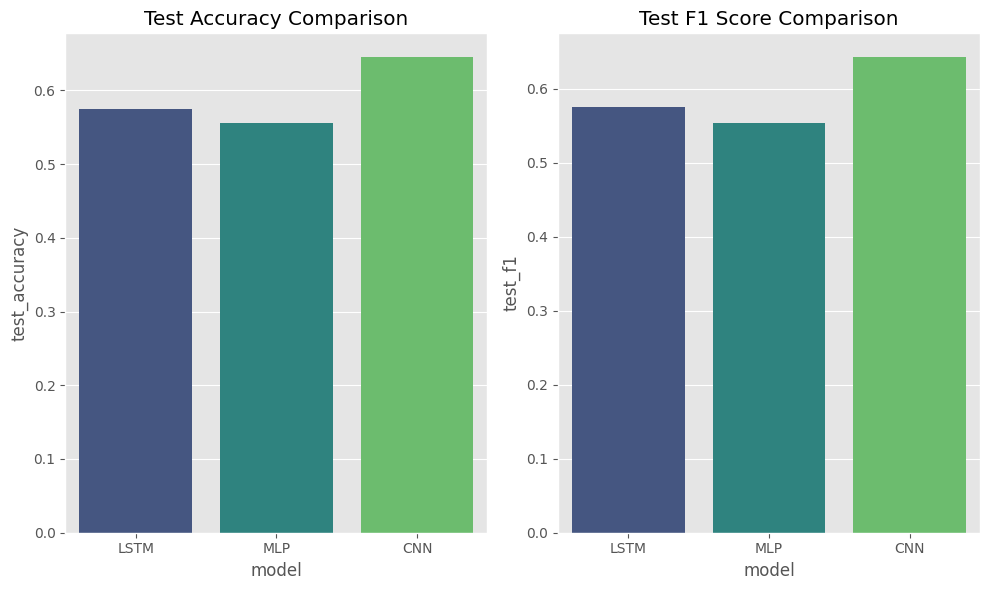

In [ ]:
from IPython.display import display

def train_and_evaluate(df, class_names, dataset_type, text_col):
    results = []
    indices = np.arange(len(df))
    y = df['encoded_labels'].values
    train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)

    # LSTM Processing
    print("\n=== LSTM Processing ===")
    lstm_data = prepare_lstm_data(df, text_col)
    global vocab_size, max_length, tokenizer
    vocab_size = lstm_data['vocab_size']
    max_length = lstm_data['max_length']
    tokenizer = lstm_data['tokenizer']

    X_tensor = torch.tensor(lstm_data['sequences'], dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)
    X_train, X_test = X_tensor[train_indices], X_tensor[test_indices]
    y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]

    if dataset_type == 'amazon':
        smote = SMOTE(random_state=42)
        X_train_np = X_train.numpy().reshape(X_train.shape[0], -1)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train.numpy())
        X_train = torch.tensor(X_train_resampled.reshape(-1, X_train.shape[1]), dtype=torch.long)
        y_train = torch.tensor(y_train_resampled, dtype=torch.long)

    # LSTM Validation
    lstm_val_results = validate_dl_model(
        X=lstm_data['sequences'],
        y=y,
        dataset_type=dataset_type,
        model_class=LSTMClassifier,
        model_kwargs={
            'vocab_size': vocab_size,
            'embedding_dim': 100,
            'hidden_dim': 128,
            'output_dim': len(class_names),
            'pad_idx': 0,
            'bidirectional': True,
            'dropout': 0.5
        }
    )

    # LSTM Final Training
    lstm_model = LSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=100,
        hidden_dim=128,
        output_dim=len(class_names),
        pad_idx=0,
        bidirectional=True,
        dropout=0.5
    ).to(device)

    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    best_val_loss = float('inf')
    patience, patience_counter = 3, 0
    for epoch in range(10):
        train_loss, train_acc = train_model(lstm_model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate_model(lstm_model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/10 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(lstm_model.state_dict(), 'best_lstm_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    lstm_model.load_state_dict(torch.load('best_lstm_model.pt'))
    _, test_acc, test_preds, test_true = evaluate_model(lstm_model, test_loader, criterion, device)
    lstm_accuracy = accuracy_score(test_true, test_preds)
    lstm_f1 = f1_score(test_true, test_preds, average='weighted')
    results.append({
        'model': 'LSTM',
        'val_accuracy': lstm_val_results['mean_accuracy'],
        'test_accuracy': lstm_accuracy,
        'test_f1': lstm_f1
    })

    # MLP Processing
    print("\n=== MLP Processing ===")
    mlp_val_results = validate_dl_model(
        X=lstm_data['sequences'],
        y=y,
        dataset_type=dataset_type,
        model_class=MLPClassifier,
        model_kwargs={
            'vocab_size': vocab_size,
            'embedding_dim': 100,
            'hidden_dims': 256,
            'output_dim': len(class_names),
            'pad_idx': 0,
            'max_length': max_length
        }
    )

    mlp_model = MLPClassifier(
        vocab_size=vocab_size,
        embedding_dim=100,
        hidden_dims=256,
        output_dim=len(class_names),
        pad_idx=0,
        max_length=max_length
    ).to(device)

    optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    best_val_loss = float('inf')
    for epoch in range(10):
        train_loss, train_acc = train_model(mlp_model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate_model(mlp_model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/10 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(mlp_model.state_dict(), 'best_mlp_model.pt')

    mlp_model.load_state_dict(torch.load('best_mlp_model.pt'))
    _, test_acc, test_preds, test_true = evaluate_model(mlp_model, test_loader, criterion, device)
    mlp_accuracy = accuracy_score(test_true, test_preds)
    mlp_f1 = f1_score(test_true, test_preds, average='weighted')
    results.append({
        'model': 'MLP',
        'val_accuracy': mlp_val_results['mean_accuracy'],
        'test_accuracy': mlp_accuracy,
        'test_f1': mlp_f1
    })

    # CNN Processing
    print("\n=== CNN Processing ===")
    cnn_val_results = validate_dl_model(
        X=lstm_data['sequences'],
        y=y,
        dataset_type=dataset_type,
        model_class=CNNClassifier,
        model_kwargs={
            'vocab_size': vocab_size,
            'embedding_dim': 100,
            'num_filters': 100,
            'filter_sizes': [3,4,5],
            'output_dim': len(class_names),
            'pad_idx': 0
        }
    )

    cnn_model = CNNClassifier(
        vocab_size=vocab_size,
        embedding_dim=100,
        num_filters=100,
        filter_sizes=[3,4,5],
        output_dim=len(class_names),
        pad_idx=0
    ).to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    for epoch in range(10):
        train_loss, train_acc = train_model(cnn_model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate_model(cnn_model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/10 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(cnn_model.state_dict(), 'best_cnn_model.pt')

    cnn_model.load_state_dict(torch.load('best_cnn_model.pt'))
    _, test_acc, test_preds, test_true = evaluate_model(cnn_model, test_loader, criterion, device)
    cnn_accuracy = accuracy_score(test_true, test_preds)
    cnn_f1 = f1_score(test_true, test_preds, average='weighted')
    results.append({
        'model': 'CNN',
        'val_accuracy': cnn_val_results['mean_accuracy'],
        'test_accuracy': cnn_accuracy,
        'test_f1': cnn_f1
    })

    # Model Comparison
    print("\n=== Model Comparison ===")
    comparison_df = pd.DataFrame(results)
    print(comparison_df)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='test_accuracy', data=comparison_df, palette='viridis')
    plt.title('Test Accuracy Comparison')
    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='test_f1', data=comparison_df, palette='viridis')
    plt.title('Test F1 Score Comparison')
    plt.tight_layout()
    plt.show()

    return lstm_model, comparison_df

lstm_model, results = train_and_evaluate(df_amazon, class_names_amazon, dataset_type_amazon, text_col_amazon)
lstm_model, results = train_and_evaluate(df_imdb, class_names_imdb, dataset_type_imdb, text_col_imdb)

## **Section 9: Model Saving and Prediction**


=== LSTM Processing ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 0.6980 | Train Acc: 0.5162 | Val Loss: 0.6908 | Val Acc: 0.5268
Epoch 2/5 | Train Loss: 0.6731 | Train Acc: 0.5825 | Val Loss: 0.6910 | Val Acc: 0.5402
Epoch 3/5 | Train Loss: 0.6394 | Train Acc: 0.6787 | Val Loss: 0.6855 | Val Acc: 0.5536
Epoch 4/5 | Train Loss: 0.5842 | Train Acc: 0.7238 | Val Loss: 0.6974 | Val Acc: 0.4955
Epoch 5/5 | Train Loss: 0.4848 | Train Acc: 0.7875 | Val Loss: 0.7050 | Val Acc: 0.5893

Training fold 2/5...
Epoch 1/5 | Train Loss: 0.6948 | Train Acc: 0.5212 | Val Loss: 0.7015 | Val Acc: 0.4420
Epoch 2/5 | Train Loss: 0.6620 | Train Acc: 0.6412 | Val Loss: 0.7148 | Val Acc: 0.4464
Epoch 3/5 | Train Loss: 0.6190 | Train Acc: 0.7000 | Val Loss: 0.7357 | Val Acc: 0.4866

Training fold 3/5...
Epoch 1/5 | Train Loss: 0.6976 | Train Acc: 0.4875 | Val Loss: 0.7032 | Val Acc: 0.4509
Epoch 2/5 | Train Loss: 0.6679 | Train Acc: 0.6300 | Val Loss: 0.7080 | Val Acc: 0.4866
Epoch 3/5 | Train Loss: 0.637

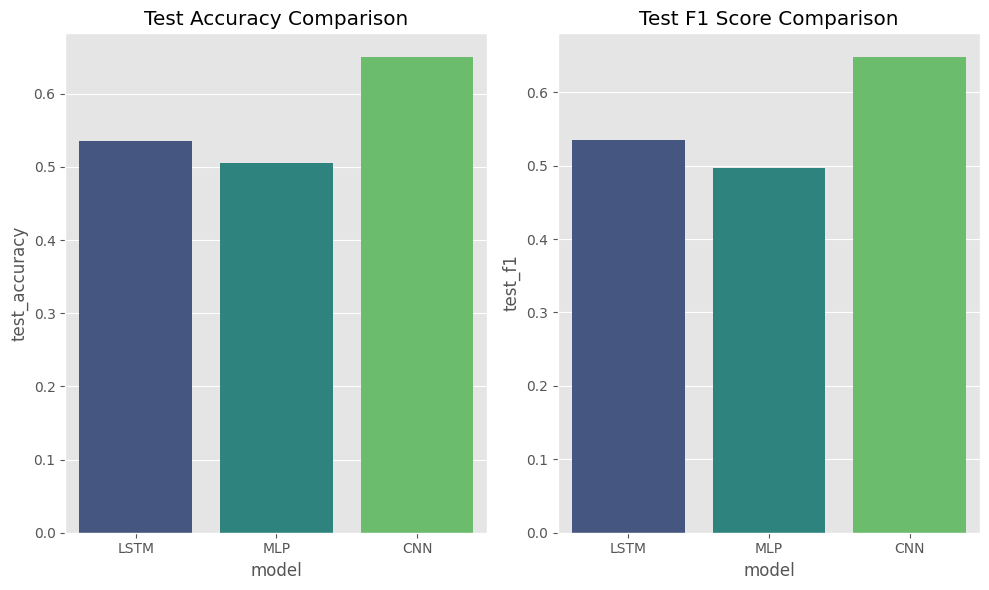

{'predicted_class': 'negative', 'confidence': 0.5183570384979248, 'class_probabilities': {'negative': 0.5183570384979248, 'positive': 0.4816429316997528}}


In [ ]:
def save_model(model, tokenizer, class_names, output_path='model.pkl'):
    """Save trained model and tokenizer"""
    model_data = {
        'model_state': model.state_dict(),
        'tokenizer': tokenizer,
        'class_names': class_names,
        'vocab_size': vocab_size,
        'max_length': max_length
    }
    joblib.dump(model_data, output_path)
    print(f"Model saved to {output_path}")

def predict(text, model, tokenizer, class_names):
    """Make prediction with trained model"""
    model.eval()

    # Preprocess text
    processed_text = preprocess_text(text, 'imdb') # Assuming 'imdb' is the default dataset type for prediction

    # Tokenize
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad sequence
    if len(sequence[0]) < max_length:
        sequence[0] = sequence[0] + [0] * (max_length - len(sequence[0]))
    else:
        sequence[0] = sequence[0][:max_length]

    # Convert to tensor
    tensor = torch.tensor(sequence, dtype=torch.long).to(device)

    # Predict
    with torch.no_grad():
        output = model(tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]
    probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()

    class_probs = {class_name: float(prob) for class_name, prob in zip(class_names, probabilities)}

    return {
        'predicted_class': predicted_class,
        'confidence': float(probabilities[predicted.item()]),
        'class_probabilities': class_probs
    }

# Assuming df_imdb, class_names_imdb, text_col_imdb are defined from your data loading section
lstm_model, _ = train_and_evaluate(df_imdb, class_names_imdb, 'imdb', text_col_imdb) # Train and get the model

sample_text = "This product was absolutely amazing!"
prediction = predict(sample_text, lstm_model, tokenizer, class_names_imdb) # Use the trained model and correct class names
print(prediction)

## **Section 10: Real-world Validation**


########################################
Processing AMAZON dataset
########################################



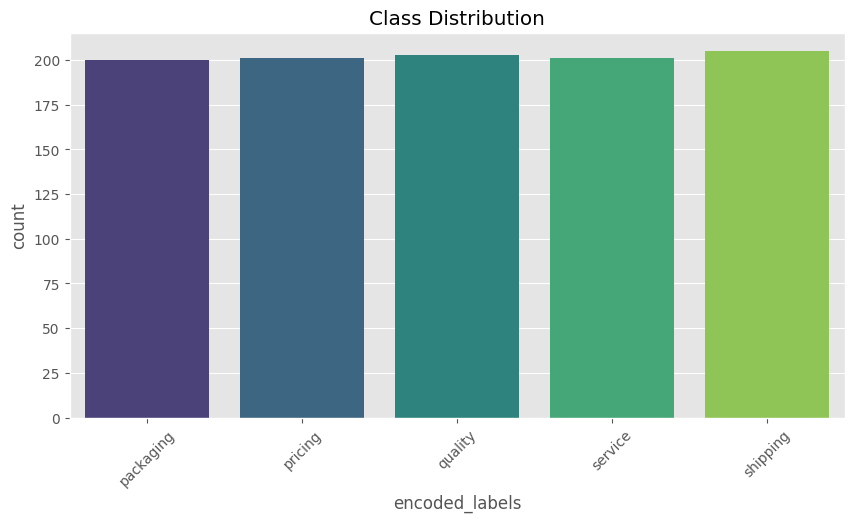

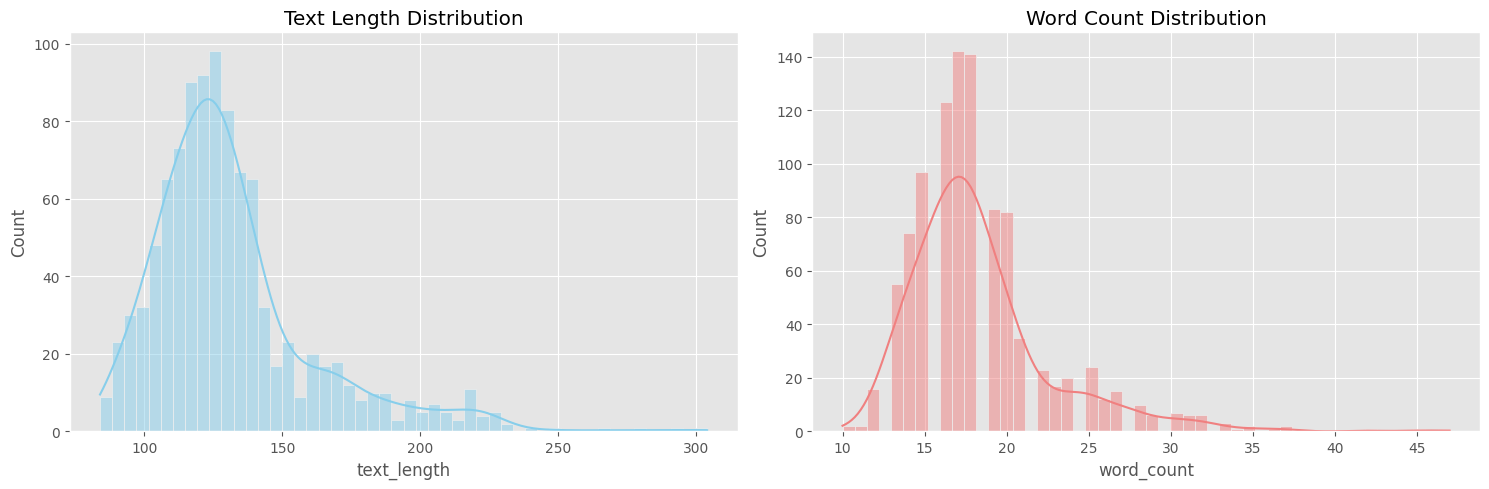


=== Processing LSTM Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 1.5195 | Train Acc: 0.4423 | Val Loss: 1.4049 | Val Acc: 0.6518
Epoch 2/5 | Train Loss: 1.2065 | Train Acc: 0.7236 | Val Loss: 1.0024 | Val Acc: 0.7384
Epoch 3/5 | Train Loss: 0.7683 | Train Acc: 0.7954 | Val Loss: 0.6170 | Val Acc: 0.8527
Epoch 4/5 | Train Loss: 0.4103 | Train Acc: 0.8995 | Val Loss: 0.4329 | Val Acc: 0.8929
Epoch 5/5 | Train Loss: 0.1948 | Train Acc: 0.9584 | Val Loss: 0.3234 | Val Acc: 0.9054

Training fold 2/5...
Epoch 1/5 | Train Loss: 1.5306 | Train Acc: 0.4471 | Val Loss: 1.4183 | Val Acc: 0.6705
Epoch 2/5 | Train Loss: 1.2126 | Train Acc: 0.7642 | Val Loss: 1.0411 | Val Acc: 0.7839
Epoch 3/5 | Train Loss: 0.7550 | Train Acc: 0.8478 | Val Loss: 0.6661 | Val Acc: 0.8098
Epoch 4/5 | Train Loss: 0.4020 | Train Acc: 0.9255 | Val Loss: 0.4366 | Val Acc: 0.8652
Epoch 5/5 | Train Loss: 0.2009 | Train Acc: 0.9572 | Val Loss: 0.3742 | Val Acc: 0.8830

Training fold 3/5...
Epoch 1/5 | Train Loss:

<Figure size 800x600 with 0 Axes>

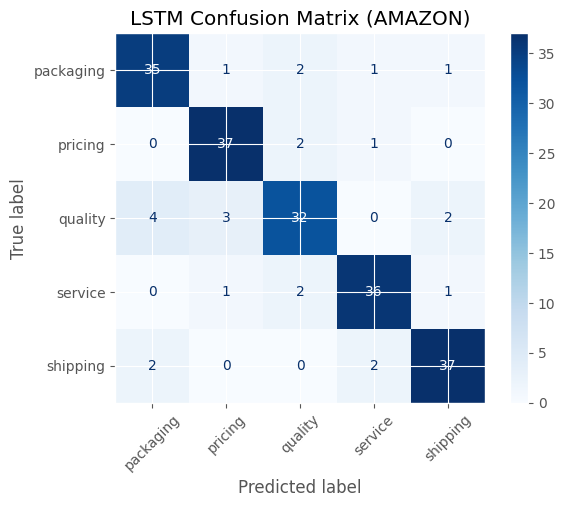


=== Processing CNN Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 1.5847 | Train Acc: 0.3409 | Val Loss: 1.2545 | Val Acc: 0.4884
Epoch 2/5 | Train Loss: 0.9806 | Train Acc: 0.6425 | Val Loss: 0.9698 | Val Acc: 0.7232
Epoch 3/5 | Train Loss: 0.6607 | Train Acc: 0.8291 | Val Loss: 0.7801 | Val Acc: 0.8089
Epoch 4/5 | Train Loss: 0.4588 | Train Acc: 0.8899 | Val Loss: 0.6575 | Val Acc: 0.8455
Epoch 5/5 | Train Loss: 0.3469 | Train Acc: 0.9236 | Val Loss: 0.5794 | Val Acc: 0.8500

Training fold 2/5...
Epoch 1/5 | Train Loss: 1.5459 | Train Acc: 0.3387 | Val Loss: 1.2143 | Val Acc: 0.6009
Epoch 2/5 | Train Loss: 0.9647 | Train Acc: 0.6642 | Val Loss: 0.9815 | Val Acc: 0.7420
Epoch 3/5 | Train Loss: 0.6330 | Train Acc: 0.8435 | Val Loss: 0.8000 | Val Acc: 0.8054
Epoch 4/5 | Train Loss: 0.4320 | Train Acc: 0.9180 | Val Loss: 0.6903 | Val Acc: 0.8232
Epoch 5/5 | Train Loss: 0.3324 | Train Acc: 0.9264 | Val Loss: 0.6146 | Val Acc: 0.8143

Training fold 3/5...
Epoch 1/5 | Train Loss: 

<Figure size 800x600 with 0 Axes>

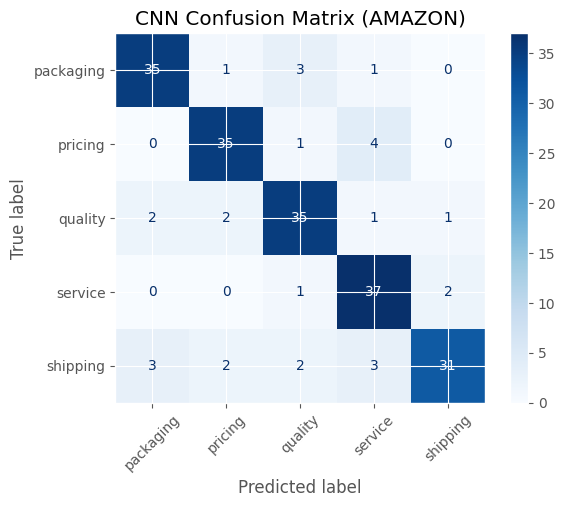


=== Processing MLP Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 1.3451 | Train Acc: 0.5349 | Val Loss: 0.8548 | Val Acc: 0.8143
Epoch 2/5 | Train Loss: 0.3371 | Train Acc: 0.9325 | Val Loss: 0.4075 | Val Acc: 0.8545
Epoch 3/5 | Train Loss: 0.0532 | Train Acc: 0.9868 | Val Loss: 0.4343 | Val Acc: 0.8500
Epoch 4/5 | Train Loss: 0.0164 | Train Acc: 0.9988 | Val Loss: 0.4560 | Val Acc: 0.8500

Training fold 2/5...
Epoch 1/5 | Train Loss: 1.3742 | Train Acc: 0.5325 | Val Loss: 0.9036 | Val Acc: 0.7884
Epoch 2/5 | Train Loss: 0.3588 | Train Acc: 0.9401 | Val Loss: 0.4677 | Val Acc: 0.8187
Epoch 3/5 | Train Loss: 0.0344 | Train Acc: 0.9957 | Val Loss: 0.4643 | Val Acc: 0.8420
Epoch 4/5 | Train Loss: 0.0150 | Train Acc: 0.9964 | Val Loss: 0.4637 | Val Acc: 0.8330
Epoch 5/5 | Train Loss: 0.0068 | Train Acc: 0.9988 | Val Loss: 0.4575 | Val Acc: 0.8375

Training fold 3/5...
Epoch 1/5 | Train Loss: 1.3811 | Train Acc: 0.5048 | Val Loss: 0.9593 | Val Acc: 0.7741
Epoch 2/5 | Train Loss: 

<Figure size 800x600 with 0 Axes>

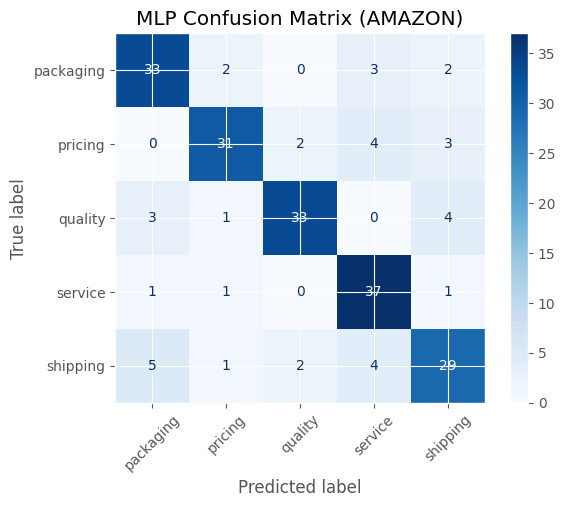


Real-World Validation for AMAZON Dataset

Example 1:
Text: The product arrived damaged and the packaging was terrible.

Predictions:
LSTM:
  Predicted Class: quality
  Confidence: 0.6370
  Class Probabilities:
    packaging: 0.1025
    pricing: 0.0612
    quality: 0.6370
    service: 0.0765
    shipping: 0.1228

CNN:
  Predicted Class: service
  Confidence: 0.7974
  Class Probabilities:
    packaging: 0.0751
    pricing: 0.0536
    quality: 0.0324
    service: 0.7974
    shipping: 0.0415

MLP:
  Predicted Class: packaging
  Confidence: 0.8409
  Class Probabilities:
    packaging: 0.8409
    pricing: 0.0188
    quality: 0.0457
    service: 0.0626
    shipping: 0.0319

------------------------------------------------------------

Example 2:
Text: Excellent value for money, works perfectly!

Predictions:
LSTM:
  Predicted Class: service
  Confidence: 0.4457
  Class Probabilities:
    packaging: 0.1686
    pricing: 0.0377
    quality: 0.3025
    service: 0.4457
    shipping: 0.0454

CNN:


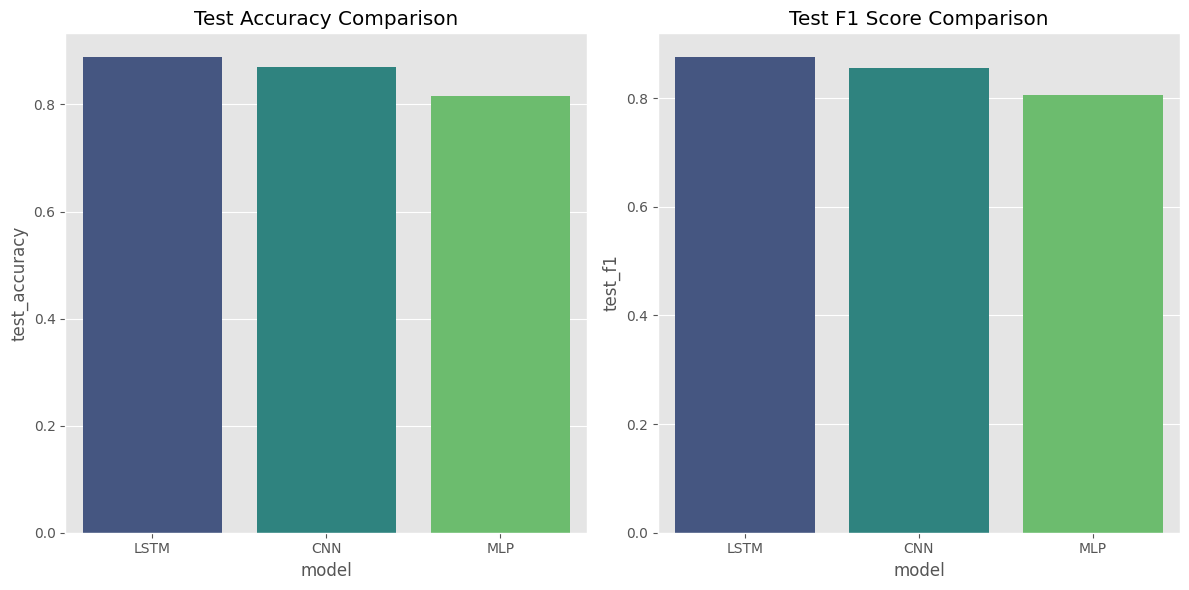


Completed processing AMAZON dataset

########################################
Processing IMDB dataset
########################################



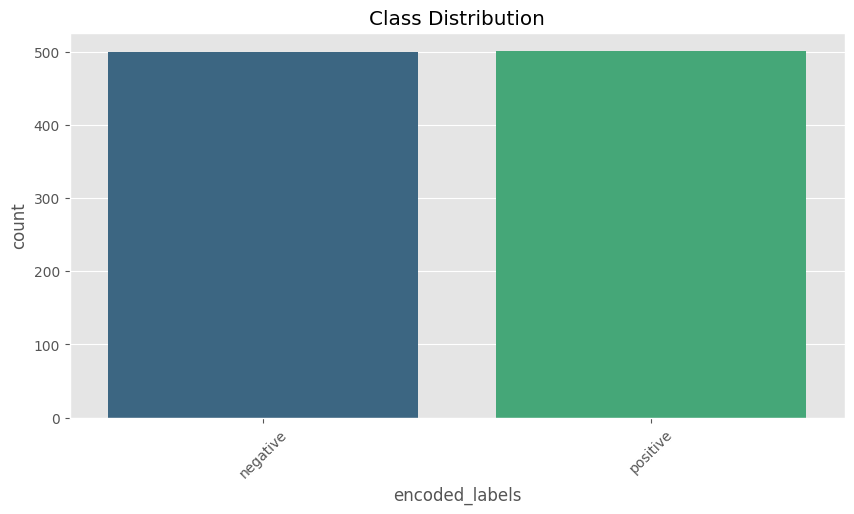

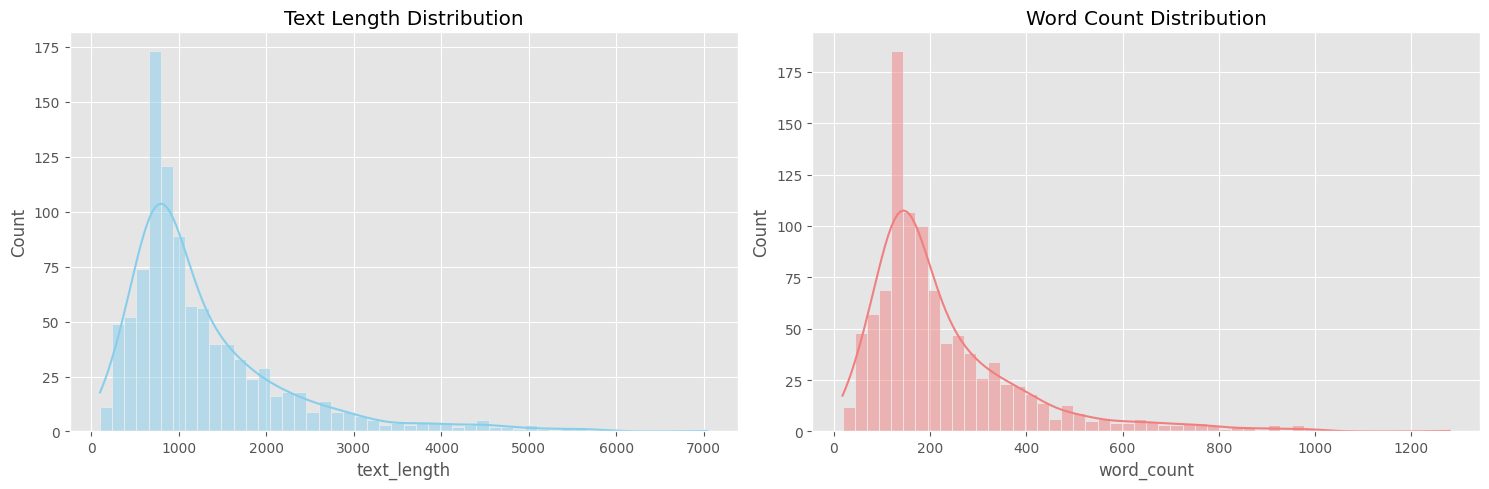


=== Processing LSTM Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 0.6992 | Train Acc: 0.4863 | Val Loss: 0.6887 | Val Acc: 0.4777
Epoch 2/5 | Train Loss: 0.6692 | Train Acc: 0.6200 | Val Loss: 0.6848 | Val Acc: 0.5491
Epoch 3/5 | Train Loss: 0.6381 | Train Acc: 0.6975 | Val Loss: 0.6808 | Val Acc: 0.5536
Epoch 4/5 | Train Loss: 0.5731 | Train Acc: 0.7538 | Val Loss: 0.6833 | Val Acc: 0.6071
Epoch 5/5 | Train Loss: 0.4741 | Train Acc: 0.7800 | Val Loss: 0.7176 | Val Acc: 0.5625

Training fold 2/5...
Epoch 1/5 | Train Loss: 0.6990 | Train Acc: 0.4838 | Val Loss: 0.7007 | Val Acc: 0.4464
Epoch 2/5 | Train Loss: 0.6609 | Train Acc: 0.6425 | Val Loss: 0.7101 | Val Acc: 0.4688
Epoch 3/5 | Train Loss: 0.6258 | Train Acc: 0.6925 | Val Loss: 0.7330 | Val Acc: 0.4688

Training fold 3/5...
Epoch 1/5 | Train Loss: 0.6941 | Train Acc: 0.5188 | Val Loss: 0.7101 | Val Acc: 0.4330
Epoch 2/5 | Train Loss: 0.6603 | Train Acc: 0.6462 | Val Loss: 0.7125 | Val Acc: 0.4286
Epoch 3/5 | Train Loss:

<Figure size 800x600 with 0 Axes>

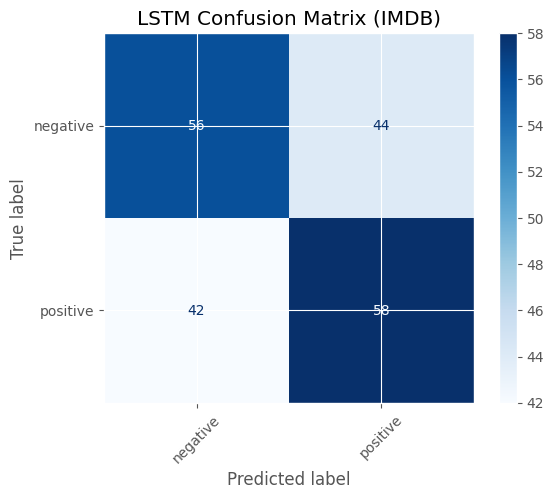


=== Processing CNN Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 0.8736 | Train Acc: 0.5262 | Val Loss: 0.7066 | Val Acc: 0.5089
Epoch 2/5 | Train Loss: 0.7096 | Train Acc: 0.6038 | Val Loss: 0.6773 | Val Acc: 0.5804
Epoch 3/5 | Train Loss: 0.5983 | Train Acc: 0.6850 | Val Loss: 0.6632 | Val Acc: 0.6027
Epoch 4/5 | Train Loss: 0.5213 | Train Acc: 0.7200 | Val Loss: 0.6879 | Val Acc: 0.5134
Epoch 5/5 | Train Loss: 0.5063 | Train Acc: 0.7350 | Val Loss: 0.6568 | Val Acc: 0.6116

Training fold 2/5...
Epoch 1/5 | Train Loss: 0.8737 | Train Acc: 0.5150 | Val Loss: 0.6758 | Val Acc: 0.5580
Epoch 2/5 | Train Loss: 0.7407 | Train Acc: 0.5863 | Val Loss: 0.6863 | Val Acc: 0.5625
Epoch 3/5 | Train Loss: 0.5717 | Train Acc: 0.6950 | Val Loss: 0.6668 | Val Acc: 0.6161
Epoch 4/5 | Train Loss: 0.4929 | Train Acc: 0.7588 | Val Loss: 0.7108 | Val Acc: 0.5491
Epoch 5/5 | Train Loss: 0.4407 | Train Acc: 0.7950 | Val Loss: 0.6489 | Val Acc: 0.6429

Training fold 3/5...
Epoch 1/5 | Train Loss: 

<Figure size 800x600 with 0 Axes>

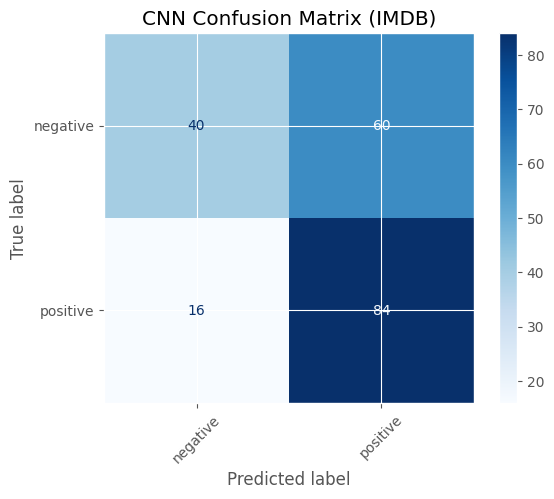


=== Processing MLP Model ===

Training fold 1/5...
Epoch 1/5 | Train Loss: 0.7161 | Train Acc: 0.5000 | Val Loss: 0.6957 | Val Acc: 0.5268
Epoch 2/5 | Train Loss: 0.3425 | Train Acc: 0.8650 | Val Loss: 0.8927 | Val Acc: 0.5000
Epoch 3/5 | Train Loss: 0.0897 | Train Acc: 0.9750 | Val Loss: 1.3064 | Val Acc: 0.4196

Training fold 2/5...
Epoch 1/5 | Train Loss: 0.7231 | Train Acc: 0.4838 | Val Loss: 0.6922 | Val Acc: 0.5312
Epoch 2/5 | Train Loss: 0.3128 | Train Acc: 0.8950 | Val Loss: 0.8633 | Val Acc: 0.5312
Epoch 3/5 | Train Loss: 0.0763 | Train Acc: 0.9775 | Val Loss: 1.1652 | Val Acc: 0.5312

Training fold 3/5...
Epoch 1/5 | Train Loss: 0.7179 | Train Acc: 0.4875 | Val Loss: 0.7024 | Val Acc: 0.4732
Epoch 2/5 | Train Loss: 0.3242 | Train Acc: 0.8838 | Val Loss: 0.8628 | Val Acc: 0.5089
Epoch 3/5 | Train Loss: 0.0768 | Train Acc: 0.9762 | Val Loss: 1.1814 | Val Acc: 0.5268

Training fold 4/5...
Epoch 1/5 | Train Loss: 0.7223 | Train Acc: 0.5062 | Val Loss: 0.7196 | Val Acc: 0.4643
Ep

<Figure size 800x600 with 0 Axes>

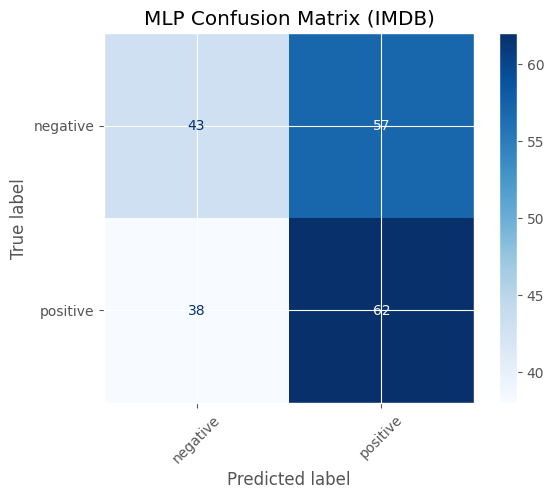


Real-World Validation for IMDB Dataset

Example 1:
Text: This movie was a complete waste of time.

Predictions:
LSTM:
  Predicted Class: negative
  Confidence: 0.5262
  Class Probabilities:
    negative: 0.5262
    positive: 0.4738

CNN:
  Predicted Class: positive
  Confidence: 0.6006
  Class Probabilities:
    negative: 0.3994
    positive: 0.6006

MLP:
  Predicted Class: positive
  Confidence: 0.5005
  Class Probabilities:
    negative: 0.4995
    positive: 0.5005

------------------------------------------------------------

Example 2:
Text: Brilliant acting and captivating storyline!

Predictions:
LSTM:
  Predicted Class: negative
  Confidence: 0.5174
  Class Probabilities:
    negative: 0.5174
    positive: 0.4826

CNN:
  Predicted Class: positive
  Confidence: 0.5769
  Class Probabilities:
    negative: 0.4231
    positive: 0.5769

MLP:
  Predicted Class: positive
  Confidence: 0.5185
  Class Probabilities:
    negative: 0.4815
    positive: 0.5185

----------------------------

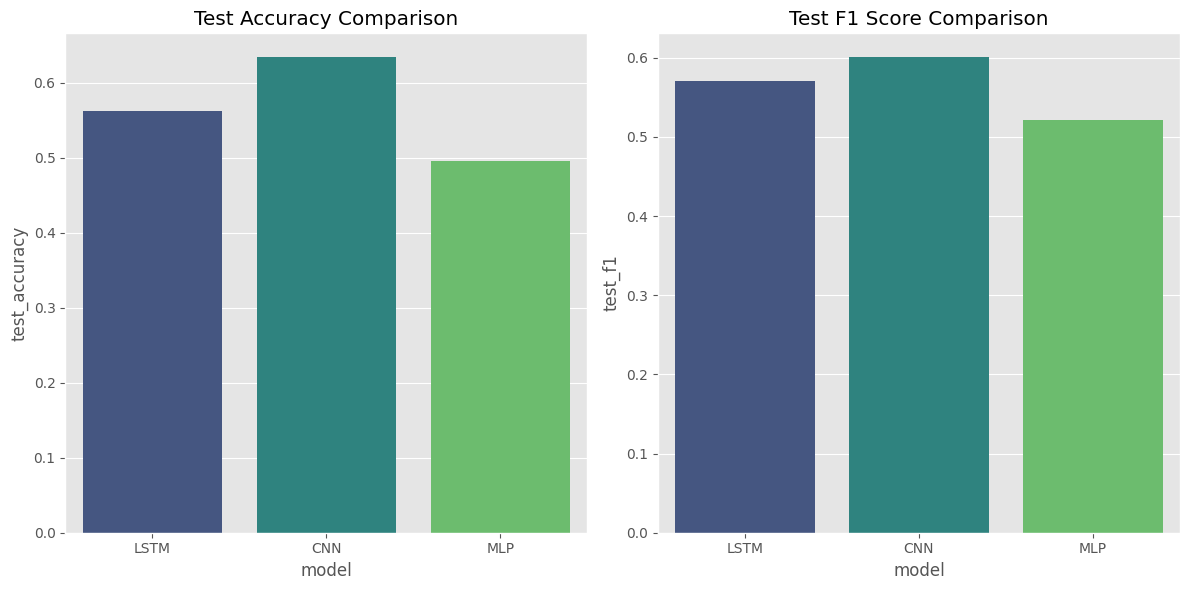


Completed processing IMDB dataset

All datasets processed successfully!


In [ ]:
def validate_on_real_data(trained_models, tokenizer, label_encoder, max_length, texts, dataset_name, dataset_type):
    """Validate trained models on real-world text examples"""
    print(f"\n{'='*60}")
    print(f"Real-World Validation for {dataset_name.upper()} Dataset")
    print(f"{'='*60}")

    for idx, text in enumerate(texts):
        print(f"\nExample {idx+1}:")
        print(f"Text: {text}")

        # Preprocess text
        cleaned_text = preprocess_text(text, dataset_type)

        # Tokenize and pad sequence
        sequence = tokenizer.texts_to_sequences([cleaned_text])[0]
        if len(sequence) < max_length:
            padded_sequence = sequence + [0] * (max_length - len(sequence))
        else:
            padded_sequence = sequence[:max_length]

        # Convert to tensor
        input_tensor = torch.tensor([padded_sequence], dtype=torch.long).to(device)

        # Get predictions from all models
        predictions = {}
        for model_name, model in trained_models.items():
            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]
                predicted_idx = np.argmax(probabilities)
                predictions[model_name] = {
                    'class': label_encoder.classes_[predicted_idx],
                    'confidence': probabilities[predicted_idx],
                    'probabilities': probabilities
                }

        # Display results
        print("\nPredictions:")
        for model_name, pred in predictions.items():
            print(f"{model_name}:")
            print(f"  Predicted Class: {pred['class']}")
            print(f"  Confidence: {pred['confidence']:.4f}")
            print("  Class Probabilities:")
            for cls, prob in zip(label_encoder.classes_, pred['probabilities']):
                print(f"    {cls}: {prob:.4f}")
            print()
        print("-"*60)

def process_dataset(dataset_name, path):
    print(f"\n{'#'*40}")
    print(f"Processing {dataset_name.upper()} dataset")
    print(f"{'#'*40}\n")

    # Load and preprocess data
    df, class_names, dataset_type, text_col, target_col, le = load_data(path)
    df['cleaned_text'] = df[text_col].apply(lambda text: preprocess_text(text, dataset_type))

    # Show EDA
    show_eda(df, class_names, text_col)

    # Prepare sequence data for DL models
    sequence_data = prepare_lstm_data(df, text_col)
    X = sequence_data['sequences']
    y = df['encoded_labels'].values

    # Initialize models
    models = {
        'LSTM': {
            'class': LSTMClassifier,
            'kwargs': {
                'vocab_size': sequence_data['vocab_size'],
                'embedding_dim': 100,
                'hidden_dim': 128,
                'output_dim': len(class_names),
                'pad_idx': 0,
                'bidirectional': True,
                'dropout': 0.5
            }
        },
        'CNN': {
            'class': CNNClassifier,
            'kwargs': {
                'vocab_size': sequence_data['vocab_size'],
                'embedding_dim': 100,
                'num_filters': 100,
                'filter_sizes': [3,4,5],
                'output_dim': len(class_names),
                'pad_idx': 0
            }
        },
        'MLP': {
            'class': MLPClassifier,
            'kwargs': {
                'vocab_size': sequence_data['vocab_size'],
                'embedding_dim': 100,
                'hidden_dims': 256,
                'output_dim': len(class_names),
                'pad_idx': 0,
                'max_length': sequence_data['max_length']
            }
        }
    }

    results = []
    trained_models = {}

    for model_name, model_config in models.items():
        print(f"\n=== Processing {model_name} Model ===")

        # Cross-validation
        val_results = validate_dl_model(
            X=X,
            y=y,
            dataset_type=dataset_type,
            model_class=model_config['class'],
            model_kwargs=model_config['kwargs']
        )

        # Final training
        model = model_config['class'](**model_config['kwargs']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Apply SMOTE if needed
        if dataset_type == 'amazon':
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
            X_train = X_train.reshape(-1, X.shape[1])

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.long)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        for epoch in range(10):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, _, _ = evaluate_model(model, test_loader, criterion, device)

            print(f"Epoch {epoch+1}/10 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_{model_name.lower()}_{dataset_name}_model.pt')
            else:
                patience_counter += 1
                if patience_counter >= 3:
                    break

        # Load best model
        model.load_state_dict(torch.load(f'best_{model_name.lower()}_{dataset_name}_model.pt'))
        trained_models[model_name] = model

        # Final evaluation
        _, test_acc, test_preds, test_true = evaluate_model(model, test_loader, criterion, device)
        test_f1 = f1_score(test_true, test_preds, average='weighted')

        # Save results
        results.append({
            'model': model_name,
            'val_accuracy': val_results['mean_accuracy'],
            'test_accuracy': test_acc,
            'test_f1': test_f1
        })

        # Plot confusion matrix
        plt.figure(figsize=(8,6))
        cm = confusion_matrix(test_true, test_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{model_name} Confusion Matrix ({dataset_name.upper()})')
        plt.xticks(rotation=45)
        plt.show()

    # Real-world validation
    real_world_texts = {
        'amazon': [
            "The product arrived damaged and the packaging was terrible.",
            "Excellent value for money, works perfectly!",
            "Not what I expected, poor quality materials.",
            "Fast shipping and excellent customer service."
        ],
        'imdb': [
            "This movie was a complete waste of time.",
            "Brilliant acting and captivating storyline!",
            "The plot was predictable and the acting was wooden.",
            "One of the best films I've seen this year."
        ]
    }

    validate_on_real_data(
        trained_models=trained_models,
        tokenizer=sequence_data['tokenizer'],
        label_encoder=le,
        max_length=sequence_data['max_length'],
        texts=real_world_texts[dataset_type],
        dataset_name=dataset_name,
        dataset_type=dataset_type # Pass dataset_type argument
    )

    # Model comparison
    print("\n=== Final Model Comparison ===")
    comparison_df = pd.DataFrame(results)
    print(comparison_df)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(x='model', y='test_accuracy', data=comparison_df, palette='viridis')
    plt.title('Test Accuracy Comparison')
    plt.subplot(1,2,2)
    sns.barplot(x='model', y='test_f1', data=comparison_df, palette='viridis')
    plt.title('Test F1 Score Comparison')
    plt.tight_layout()
    plt.show()

    # Save models and tokenizer
    joblib.dump({
        'label_encoder': le,
        'tokenizer': sequence_data['tokenizer'],
        'max_length': sequence_data['max_length']
    }, f'{dataset_name}_preprocessors.pkl')

    print(f"\nCompleted processing {dataset_name.upper()} dataset")

# Main execution
for dataset_name, path in DATASETS.items():
    process_dataset(dataset_name, path)

print("\nAll datasets processed successfully!")